## Check that the GA infiltration code is working

- Assumes fV = 1; will break otherwise! 

In [50]:
import sys
sys.path.append("/Users/octavia/Dropbox/SVE_v2/utilities")
sys.path.append("/Users/octavia/Dropbox/SVE_v2/model")
sys.path.append('/Users/octavia/Dropbox/SVE_v2/GW_model')

infl_modules = ['philips_infl', 'connect_SVE', 'GA_infl']
modules = ['search_functions', 'plot_functions', 'load_model_output',
           'gw_functions', 'SVE_mass_check']

for mod in modules + infl_modules:
    if mod in sys.modules: 
        del sys.modules[mod]
        

from search_functions import *
from plot_functions import *
from load_model_output import *
from SVE_mass_check import *

from GA_infl import *
from philips_infl import *
from connect_SVE import *

In [36]:
project_dir = "/Users/octavia/Dropbox/SVE_v2/"
base_name = "GA_infl_test"
base_dir = project_dir  + 'model_output/' + base_name 

print_input_params(base_dir)

batch:
	fV : 1
sim:
	Ks : 1.0, 5.0
	p : 3.0, 5.0
	H_i : -0.05, -0.1
common:
	tr : 30
	dt_print : 10


In [37]:
core = load_sims(base_dir)
core = patchy_update(core)

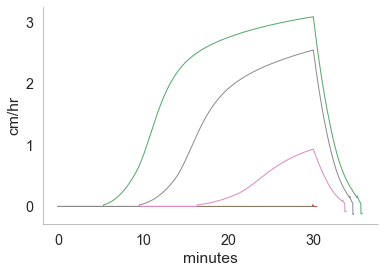

In [38]:
fig = plot_hydrographs(core)

## Make sure we don't infiltrate more than it rains:


In [39]:
core["check_infl_depth"] = core.rain_depth > core.infl_depth
core[["rain_depth", "infl_depth", "check_infl_depth"]]

,rain_depth,infl_depth,check_infl_depth
"fV-1/H_i--0.05,Ks-5.0,p-3.0/",0.015,0.0149999,True
"fV-1/H_i--0.1,Ks-5.0,p-5.0/",0.025,0.0249999,True
"fV-1/H_i--0.05,Ks-1.0,p-5.0/",0.025,0.0152314,True
"fV-1/H_i--0.1,Ks-1.0,p-3.0/",0.015,0.014939,True
"fV-1/H_i--0.05,Ks-5.0,p-5.0/",0.025,0.0249999,True
"fV-1/H_i--0.1,Ks-5.0,p-3.0/",0.015,0.0149999,True
"fV-1/H_i--0.05,Ks-1.0,p-3.0/",0.015,0.0137711,True
"fV-1/H_i--0.1,Ks-1.0,p-5.0/",0.025,0.0189792,True


# Compare GA and SVE times of ponding

In [40]:
summary = pd.DataFrame(index = core.index)

for i, key in enumerate(core.index):
    sim = core.loc[key]
    
    summary.loc[key, "t_pond_SVE"] = SVE_t_pond(sim,  threshold=2e-7)
    summary.loc[key, "t_pond_GA"]  = GA_t_pond(get_GA_param(sim))


In [41]:
max_depth = sim.hc.max(1).max(1)
ponded_inds = np.where(max_depth > 1e-7)[0]
if len(ponded_inds) > 0:
    t_pond = sim.t_print[np.min(ponded_inds[0])]

## Compare SVE-GA and GA infiltation predictions

In [42]:
sim = (core.loc[(core.Ks < core.p) & (core.H_i < 0)]).iloc[0]
print (sim.name)
param = get_GA_param(sim)

fV-1/H_i--0.05,Ks-1.0,p-5.0/


In [43]:
sim.delta_theta

0.23999999999999996

In [44]:
param

{'P': 0.012,
 'ksatV': 2.777777777777778e-06,
 'rain': 1.388888888888889e-05,
 't_rain': 1800,
 't_max': nan}

In [45]:
sim = (core.loc[(core.Ks < core.p) & (core.H_i < 0)]).iloc[0]
print (sim.name)
param = get_GA_param(sim)

res = compute_GA_infl(param)

t_pond = GA_t_pond(param)

fV-1/H_i--0.05,Ks-1.0,p-5.0/


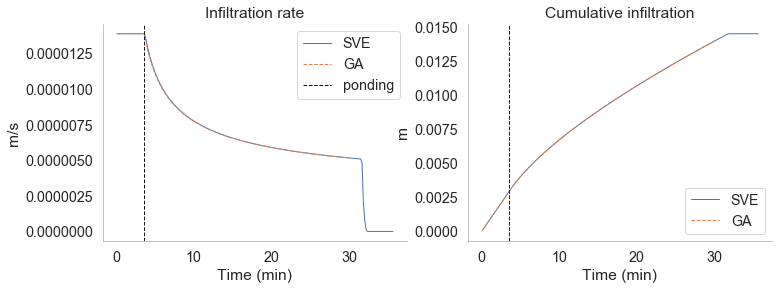

In [46]:


fig, axes = plt.subplots(1, 2, figsize = (12, 4))
ax = axes[0]
ax.plot(sim.t_print[1:]/60., sim.infl_3d[1:,0,0], label = "SVE")
ax.plot(res["t"]/60., res["f"], '--', label = "GA")

ax.set_xlabel("Time (min)")
ax.set_ylabel("m/s")
ax.axvline(t_pond/60, c = 'k', ls = '--', label = 'ponding')
ax.legend()
ax.set_title("Infiltration rate")

ax = axes[1]
ax.plot(sim.t_print[1:]/60, np.cumsum(sim.infl_3d[1:,0,0]*sim.dt_print), label = "SVE")
ax.plot(res["t"]/60., res["F_implicit"], '--', label = "GA")
ax.legend()
ax.set_ylabel("m")
ax.set_xlabel("Time (min)")
ax.set_title("Cumulative infiltration")

ax.axvline(t_pond/60, c = 'k', ls = '--', label = 'ponding')


# Comparing to Philips?

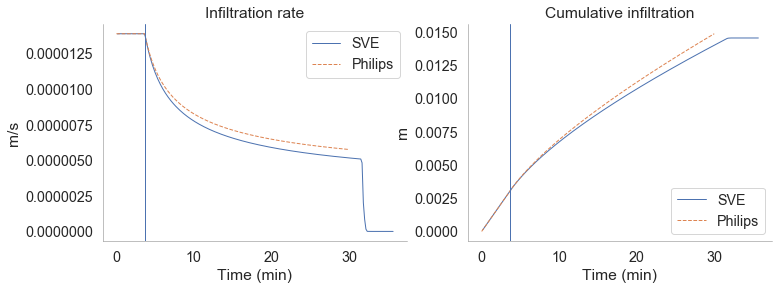

In [51]:

sim = (core.loc[(core.Ks < core.p) & (core.H_i < 0)]).iloc[0]

param = get_philip_param(sim, threshold=2e-7)
res =  compute_philip_infl(param)
t_pond = param['t_pond']

fig, axes = plt.subplots(1, 2, figsize = (12, 4))
ax = axes[0]
ax.plot(sim.t_print[1:]/60., sim.infl_3d[1:,0,0], label = "SVE")
ax.plot(res["t"]/60., res["f"], '--', label = "Philips")
ax.legend()
ax.set_xlabel("Time (min)")
ax.set_ylabel("m/s")
ax.axvline(t_pond/60)
ax.set_title("Infiltration rate")

ax = axes[1]
ax.plot(sim.t_print[1:]/60, np.cumsum(sim.infl_3d[1:,0,0]*sim.dt_print), label = "SVE")
ax.plot(res["t"]/60., res["F"], '--', label = "Philips")
ax.legend()
ax.set_ylabel("m")
ax.set_xlabel("Time (min)")
ax.set_title("Cumulative infiltration")
ax.axvline(t_pond/60)
